# **READ ME**


# 🛠️ Developer Notes & Change Guide

> 📌 Use this guide to understand how to update, modify, or extend the model and app in this notebook.

---

## 🔁 1. Update Class Labels
Modify this dictionary to match your model's output order:
```python
class_labels = {
    0: 'Normal',
    1: 'Stone',
    2: 'Cyst',
    3: 'Tumor'
}
````


## 🏋️ 2. Retrain the Model

* Go to the model training section.
* If classes are imbalanced, add this before `model.fit()`:

```python
from sklearn.utils.class_weight import compute_class_weight

classes = ['Normal', 'Stone', 'Cyst', 'Tumor']
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=train_df['category'])
class_weights_dict = dict(zip(range(len(classes)), class_weights))

model.fit(..., class_weight=class_weights_dict)
```

---

## 🖼️ 3. Change Input Image Size

* Update this in image preprocessing:

```python
img = load_img(uploaded_file, target_size=(150, 150))
```

* Also update the first Conv2D layer:

```python
Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3))
```

---

## 🤖 4. Use a Different CNN Architecture

To switch from a custom model to a pretrained one:

```python
from tensorflow.keras.applications import MobileNetV2

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
# Then add your own classification layers below
```

---

## 🎯 5. Show Prediction Confidence

To display confidence percentage:
s
```python
confidence = np.max(prediction) * 100
print(f"Confidence: {confidence:.2f}%")
```

---

## 📊 6. Evaluate on a Full Test Set

After predictions on a test set:

```python
from sklearn.metrics import classification_report

y_true = test_df['category']
y_pred = test_df['predicted category']
print(classification_report(y_true, y_pred))
```

# Deep Learning-Based Detection of Kidney Abnormalities from CT Scans

**Importing and Installing required libraries**

In [ ]:
!pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 81.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.9/319.9 kB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 119.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 98.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 115.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 6.1 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 6.31.1
    Uninstalling protobuf-6.31.1:
      Successfully uninstalled protobuf-6.31.1


In [ ]:
!pip install opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 MB 18.7 MB/s eta 0:00:00


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, Activation, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img
import random
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import cv2
from skimage.feature import hog
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [ ]:
!unzip /content/archive.zip

Streaming output truncated to the last 5000 lines.
  inflating: CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Normal/Normal- (4363).jpg  
  inflating: CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Normal/Normal- (4364).jpg  
  inflating: CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Normal/Normal- (4365).jpg  
  inflating: CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Normal/Normal- (4366).jpg  
  inflating: CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Normal/Normal- (4367).jpg  
  inflating: CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Normal/Normal- (4368).jpg  
  inflating: CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Normal/Normal- (4369).jpg  
  inflating: CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-N

**Preparing Traning Data**  

In [ ]:

folder_path = "/content/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone"

filenames = []
categories = []

for category in os.listdir(folder_path):
    category_path = os.path.join(folder_path, category)

    if os.path.isdir(category_path):
        for filename in os.listdir(category_path):
            if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
                filenames.append(os.path.join(category, filename))
                categories.append(category)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})


df.to_csv("kidneyData.csv", index=False)
print(df.head())


                filename category
0   Cyst/Cyst- (901).jpg     Cyst
1   Cyst/Cyst- (152).jpg     Cyst
2  Cyst/Cyst- (2935).jpg     Cyst
3  Cyst/Cyst- (1672).jpg     Cyst
4  Cyst/Cyst- (1187).jpg     Cyst


In [ ]:
df.tail()

,filename,category
12441,Tumor/Tumor- (499).jpg,Tumor
12442,Tumor/Tumor- (1488).jpg,Tumor
12443,Tumor/Tumor- (1474).jpg,Tumor
12444,Tumor/Tumor- (601).jpg,Tumor
12445,Tumor/Tumor- (490).jpg,Tumor


<Axes: xlabel='category'>

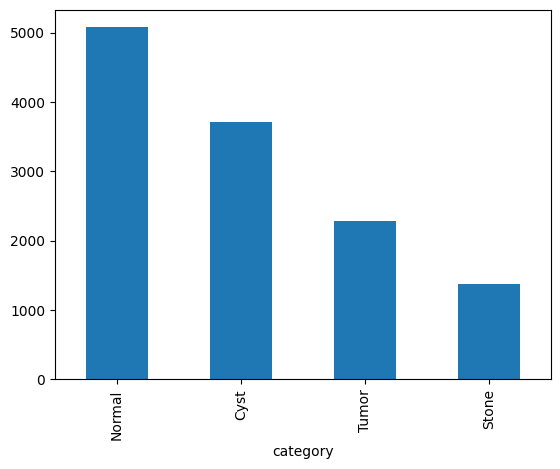

In [ ]:
df['category'].value_counts().plot.bar()

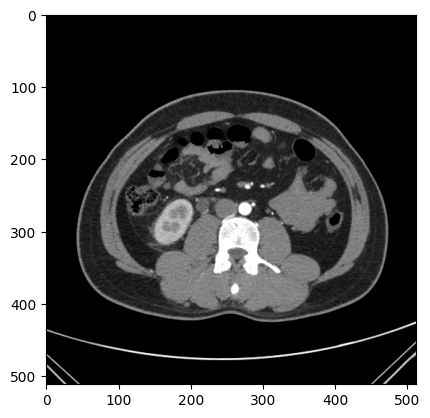

In [ ]:
sample = random.choice(filenames)
image_path = "/content/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/" + sample
image = load_img(image_path)
plt.imshow(image)
plt.show()

**Building CNN Model**  

In [ ]:
model = Sequential()

#Adding convolutional layers
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

#Adding a second convolutional layer
model.add(Conv2D(64, (3, 3) , activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Flatten())  # this converts our feature maps to 1D feature vectors
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 148, 148, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 72, 72, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 82944)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │    10,616,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,637,764 (40.58 MB)

 Trainable params: 10,637,316 (40.58 MB)

 Non-trainable params: 448 (1.75 KB)

**Early Stop**  
To prevent over fitting we will stop the learning after 10 epochs and val_loss value not decreased

In [ ]:
earlystop = EarlyStopping(patience=10)

**Learning Rate Reduction**  
We will reduce the learning rate when then accuracy not increase for 2 steps

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=2,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)

In [ ]:
callbacks = [earlystop, learning_rate_reduction]

**Preparing Data**

In [ ]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

**Train and Validation generator**  

In [ ]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

validation_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    "/content/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone",
    x_col='filename',
    y_col='category',
    target_size=(150,150),
    class_mode='categorical',
    batch_size=32
)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df,
    "/content/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone",
    x_col='filename',
    y_col='category',
    target_size=(150,150),
    class_mode='categorical',
    batch_size=32
)

Found 9956 validated image filenames belonging to 4 classes.
Found 2490 validated image filenames belonging to 4 classes.


**Visulaizing the output**

In [ ]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df,
    "/content/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone",
    x_col='filename',
    y_col='category',
    target_size=(150,150),
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


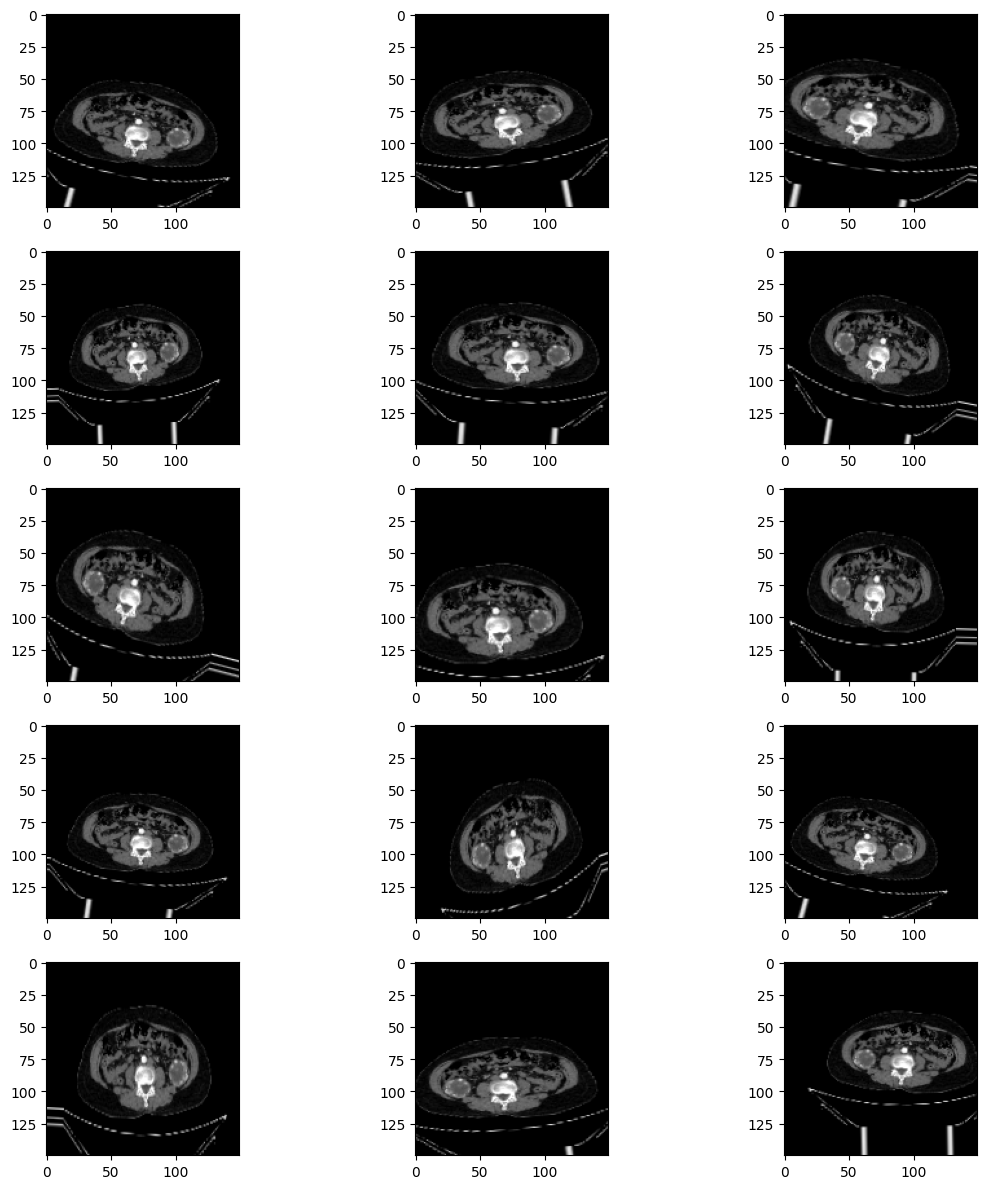

In [ ]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

**Fitting the Model**

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
history = model.fit(
    train_generator,
    epochs=5,
    validation_data=validation_generator,
    validation_steps=validate_df.shape[0]//15,
    steps_per_epoch=train_df.shape[0]//15,
    callbacks=callbacks
)

Epoch 1/5
312/663 ━━━━━━━━━━━━━━━━━━━━ 13:38 2s/step - accuracy: 0.6538 - loss: 0.9341

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


663/663 ━━━━━━━━━━━━━━━━━━━━ 754s 1s/step - accuracy: 0.6677 - loss: 0.8858 - val_accuracy: 0.1992 - val_loss: 16.4309 - learning_rate: 0.0010
Epoch 2/5
663/663 ━━━━━━━━━━━━━━━━━━━━ 755s 1s/step - accuracy: 0.7378 - loss: 0.6673 - val_accuracy: 0.2430 - val_loss: 4.7536 - learning_rate: 0.0010
Epoch 3/5
663/663 ━━━━━━━━━━━━━━━━━━━━ 750s 1s/step - accuracy: 0.7803 - loss: 0.5674 - val_accuracy: 0.8333 - val_loss: 0.4654 - learning_rate: 0.0010
Epoch 4/5
663/663 ━━━━━━━━━━━━━━━━━━━━ 748s 1s/step - accuracy: 0.7963 - loss: 0.5088 - val_accuracy: 0.7321 - val_loss: 0.7261 - learning_rate: 0.0010
Epoch 5/5
312/663 ━━━━━━━━━━━━━━━━━━━━ 13:34 2s/step - accuracy: 0.8203 - loss: 0.4459
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
663/663 ━━━━━━━━━━━━━━━━━━━━ 749s 1s/step - accuracy: 0.8235 - loss: 0.4426 - val_accuracy: 0.5064 - val_loss: 1.8199 - learning_rate: 0.0010


**Visualizing the Training history**  

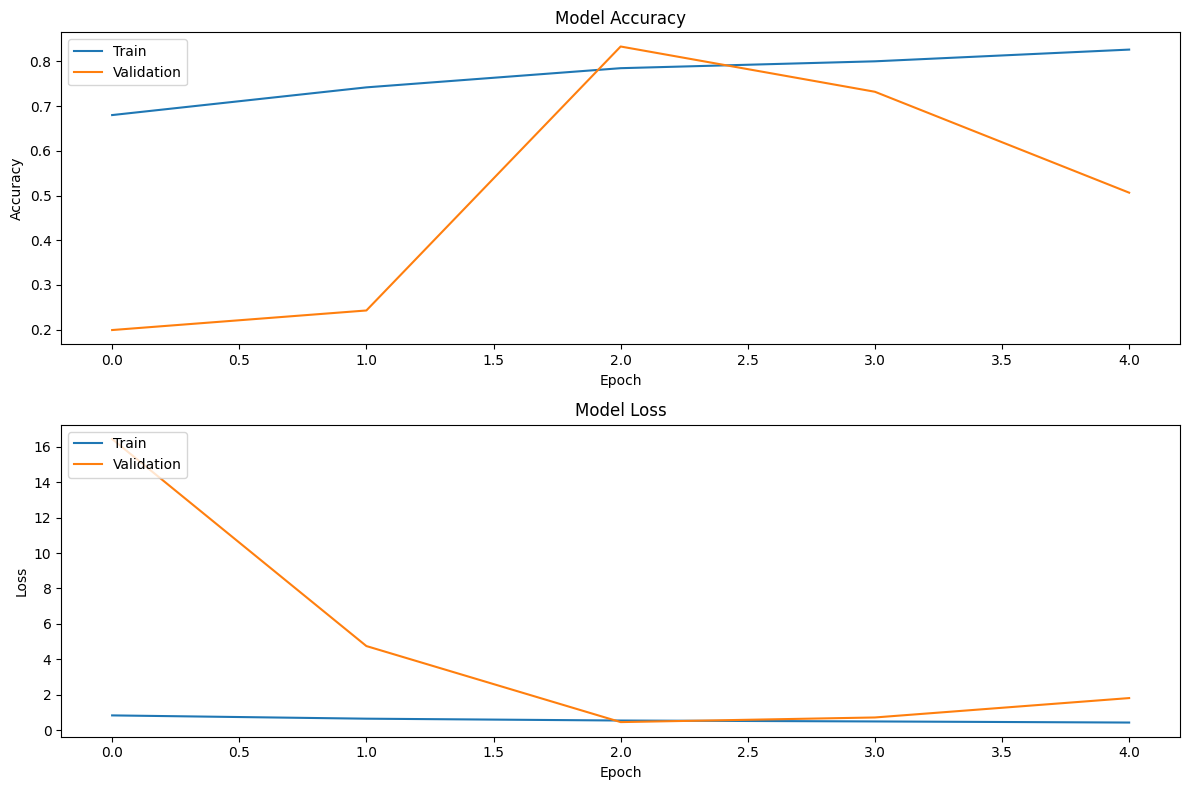

In [ ]:
# Plotting the training history
plt.figure(figsize=(12, 8))

# Plot training & validation accuracy values
plt.subplot(2, 1, 1)  # 2 rows, 1 column, first subplot
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(2, 1, 2)  # 2 rows, 1 column, second subplot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

model.save('/content/drive/My Drive/model.keras')

Mounted at /content/drive


### Testing Data

In [ ]:
test_folder_path = "/content/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone"
test_filenames = []
test_categories = []

for category in os.listdir(test_folder_path):
    test_category_path = os.path.join(test_folder_path, category)

    if os.path.isdir(test_category_path):
        for filename in os.listdir(test_category_path):
            test_filenames.append(os.path.join(category, filename))
            test_categories.append(category)

test_df = pd.DataFrame({
    'filename': test_filenames,
    'category': test_categories
})

In [ ]:
test_df

,filename,category
0,Cyst/Cyst- (901).jpg,Cyst
1,Cyst/Cyst- (152).jpg,Cyst
2,Cyst/Cyst- (2935).jpg,Cyst
3,Cyst/Cyst- (1672).jpg,Cyst
4,Cyst/Cyst- (1187).jpg,Cyst
...,...,...
12441,Tumor/Tumor- (499).jpg,Tumor
12442,Tumor/Tumor- (1488).jpg,Tumor
12443,Tumor/Tumor- (1474).jpg,Tumor
12444,Tumor/Tumor- (601).jpg,Tumor


In [ ]:
test_gen = ImageDataGenerator(rescale=1./255)

test_generator = test_gen.flow_from_dataframe(
    test_df,
    "/content/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone",
    x_col='filename',
    y_col='category',
    target_size=(150,150),
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 12446 validated image filenames belonging to 4 classes.


### Predictions

In [ ]:

import math

steps = math.ceil(test_df.shape[0] / 32)
predict = model.predict(test_generator, steps=steps)

389/389 ━━━━━━━━━━━━━━━━━━━━ 131s 337ms/step


In [ ]:
test_df['predicted category'] = np.argmax(predict, axis=-1)

In [ ]:
test_df

,filename,category,predicted category
0,Cyst/Cyst- (901).jpg,Cyst,0
1,Cyst/Cyst- (152).jpg,Cyst,0
2,Cyst/Cyst- (2935).jpg,Cyst,0
3,Cyst/Cyst- (1672).jpg,Cyst,0
4,Cyst/Cyst- (1187).jpg,Cyst,0
...,...,...,...
12441,Tumor/Tumor- (499).jpg,Tumor,3
12442,Tumor/Tumor- (1488).jpg,Tumor,0
12443,Tumor/Tumor- (1474).jpg,Tumor,0
12444,Tumor/Tumor- (601).jpg,Tumor,3


In [ ]:
# Define the mapping
label_map = {
    'Normal': 0,
    'Stone': 1,
    'Cyst': 2,
    'Tumor': 3
}

# Map actual string categories to integers
test_df['category'] = test_df['category'].map(label_map)


In [ ]:

print(test_df['predicted category'].value_counts())
# Print the accuracy of the predictions by comparing the 'category' and 'predicted category' columns
print(f"Accuracy: {(test_df['category'] == test_df['predicted category']).mean()}")

predicted category
0    7063
3    4171
1     733
2     479
Name: count, dtype: int64
Accuracy: 0.22882853928973165


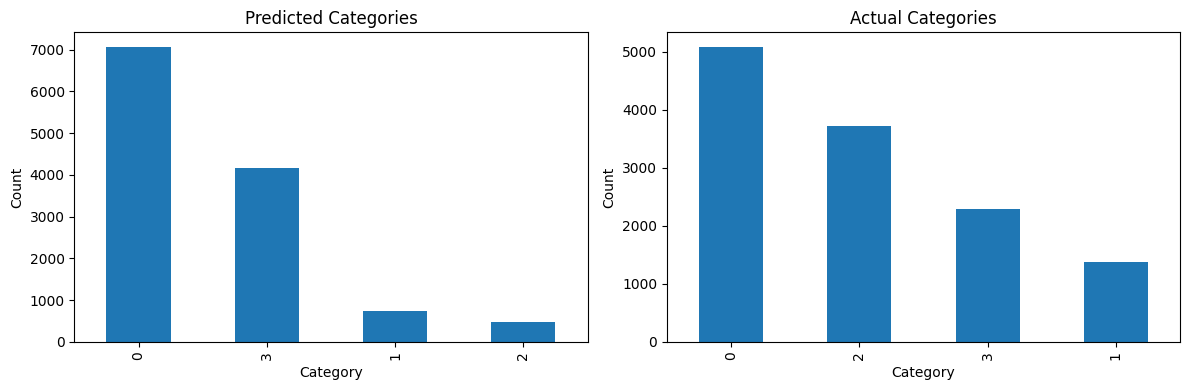

In [ ]:
plt.figure(figsize=(12, 4))

# Plot the first bar plot (predicted category)
plt.subplot(1, 2, 1)
test_df['predicted category'].value_counts().plot.bar()
plt.title('Predicted Categories')
plt.xlabel('Category')
plt.ylabel('Count')

# Plot the second bar plot (actual category)
plt.subplot(1, 2, 2)
test_df['category'].value_counts().plot.bar()
plt.title('Actual Categories')
plt.xlabel('Category')
plt.ylabel('Count')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()

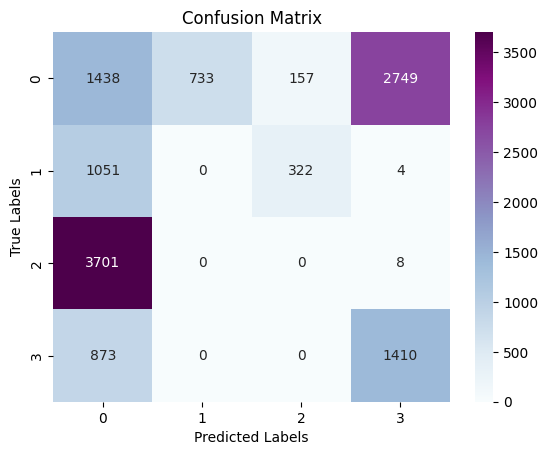

In [ ]:
cm = confusion_matrix(test_df['category'], test_df['predicted category'])

sns.heatmap(cm, annot=True, fmt='d', cmap='BuPu')

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

plt.show()

In [ ]:
model.evaluate(test_generator)

389/389 ━━━━━━━━━━━━━━━━━━━━ 132s 340ms/step - accuracy: 0.7251 - loss: 1.0927


[1.8311797380447388, 0.4954202175140381]